In [16]:
# import relevant libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import data 

df = pd.read_csv(r"C:\Users\adityamxr\Desktop\Projects\Spotify-time-series\label_encoded_streams_df.csv")

In [3]:
# verify 

df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cleaned_broad_genre,labelenc_genre
0,0.995,0.708,158648,0.1950,0,0.563,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928,unknown,500
1,0.994,0.379,282133,0.0135,0,0.901,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928,early music,138
2,0.604,0.749,104300,0.2200,0,0.000,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928,epicore,149
3,0.995,0.781,180760,0.1300,0,0.887,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928,tango,477
4,0.990,0.210,687733,0.2040,0,0.908,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928,classical,96


In [4]:
features_to_remove = ['danceability', 'duration_ms','energy', 'instrumentalness', 'liveness', 'mode','speechiness','tempo','valence','cleaned_broad_genre','popularity']

df = df.drop(columns=features_to_remove)

In [5]:
df.head()

,acousticness,explicit,loudness,year,labelenc_genre
0,0.995,0,-12.428,1928,500
1,0.994,0,-28.454,1928,138
2,0.604,0,-19.924,1928,149
3,0.995,0,-14.734,1928,477
4,0.990,0,-16.829,1928,96


In [6]:
# compute annual averages of the selected features
annual_avg_top_4 = df[["acousticness", "explicit", "loudness", "labelenc_genre", "year"]] \
    .groupby("year").mean() \
    .sort_values(by="year") \
    .reset_index()

# verify aggregation
annual_avg_top_4.head()

,year,acousticness,explicit,loudness,labelenc_genre
0,1921,0.895823,0.054688,-17.095437,342.226562
1,1922,0.939236,0.000000,-19.179958,418.625000
2,1923,0.976329,0.000000,-14.373882,304.301775
3,1924,0.935575,0.000000,-14.202304,350.063291
4,1925,0.965422,0.000000,-14.516707,354.342205


In [7]:
# create copy of original df
df2 = annual_avg_top_4.copy()
df2.head()

,year,acousticness,explicit,loudness,labelenc_genre
0,1921,0.895823,0.054688,-17.095437,342.226562
1,1922,0.939236,0.000000,-19.179958,418.625000
2,1923,0.976329,0.000000,-14.373882,304.301775
3,1924,0.935575,0.000000,-14.202304,350.063291
4,1925,0.965422,0.000000,-14.516707,354.342205


In [8]:
df2.year=pd.to_datetime(df2.year, format='%Y')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            100 non-null    datetime64[ns]
 1   acousticness    100 non-null    float64       
 2   explicit        100 non-null    float64       
 3   loudness        100 non-null    float64       
 4   labelenc_genre  100 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.0 KB


In [10]:
df2.set_index('year', inplace=True)
df2.head()

,acousticness,explicit,loudness,labelenc_genre
year,,,,
1921-01-01,0.895823,0.054688,-17.095437,342.226562
1922-01-01,0.939236,0.000000,-19.179958,418.625000
1923-01-01,0.976329,0.000000,-14.373882,304.301775
1924-01-01,0.935575,0.000000,-14.202304,350.063291
1925-01-01,0.965422,0.000000,-14.516707,354.342205


In [11]:
acousticness_df = df2[['acousticness']].copy()
explicit_df = df2[['explicit']].copy()
loudness_df = df2[['loudness']].copy()
labelenc_genre_df = df2[['labelenc_genre']].copy()

# verify 
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

            acousticness
year                    
1921-01-01      0.895823
1922-01-01      0.939236
1923-01-01      0.976329
1924-01-01      0.935575
1925-01-01      0.965422
            explicit
year                
1921-01-01  0.054688
1922-01-01  0.000000
1923-01-01  0.000000
1924-01-01  0.000000
1925-01-01  0.000000
             loudness
year                 
1921-01-01 -17.095437
1922-01-01 -19.179958
1923-01-01 -14.373882
1924-01-01 -14.202304
1925-01-01 -14.516707
            labelenc_genre
year                      
1921-01-01      342.226562
1922-01-01      418.625000
1923-01-01      304.301775
1924-01-01      350.063291
1925-01-01      354.342205


In [12]:
acousticness_df.sort_index(inplace=True)
explicit_df.sort_index(inplace=True)
loudness_df.sort_index(inplace=True)
labelenc_genre_df.sort_index(inplace=True)

# verify sorting
print(acousticness_df.head())
print(explicit_df.head())
print(loudness_df.head())
print(labelenc_genre_df.head())

            acousticness
year                    
1921-01-01      0.895823
1922-01-01      0.939236
1923-01-01      0.976329
1924-01-01      0.935575
1925-01-01      0.965422
            explicit
year                
1921-01-01  0.054688
1922-01-01  0.000000
1923-01-01  0.000000
1924-01-01  0.000000
1925-01-01  0.000000
             loudness
year                 
1921-01-01 -17.095437
1922-01-01 -19.179958
1923-01-01 -14.373882
1924-01-01 -14.202304
1925-01-01 -14.516707
            labelenc_genre
year                      
1921-01-01      342.226562
1922-01-01      418.625000
1923-01-01      304.301775
1924-01-01      350.063291
1925-01-01      354.342205


## Acousticness LSTM

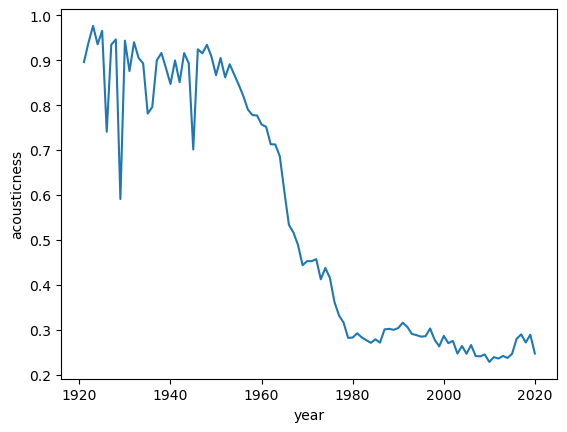

In [13]:
# plot acousticness across time

sns.lineplot(x=acousticness_df.index, y = 'acousticness', data = acousticness_df);

### The point of resampling to monthly intervals in this case is to provide the LSTM model with smoother, regular time series data for better learning of long-term trends

<Axes: xlabel='year', ylabel='acousticness'>

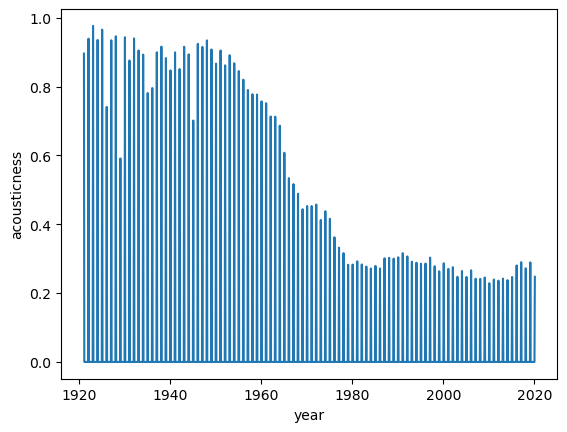

In [14]:
# resample acousticness_df by month

acousticness_df_mon = acousticness_df.resample('M').sum()

# plot
sns.lineplot(x = acousticness_df_mon.index, y='acousticness', data = acousticness_df_mon)

In [17]:
# Initialize MinMaxScaler for normalization
scaler = MinMaxScaler()

# Normalize all relevant dataframes individually
acousticness_df['acousticness_scaled'] = scaler.fit_transform(acousticness_df[['acousticness']])

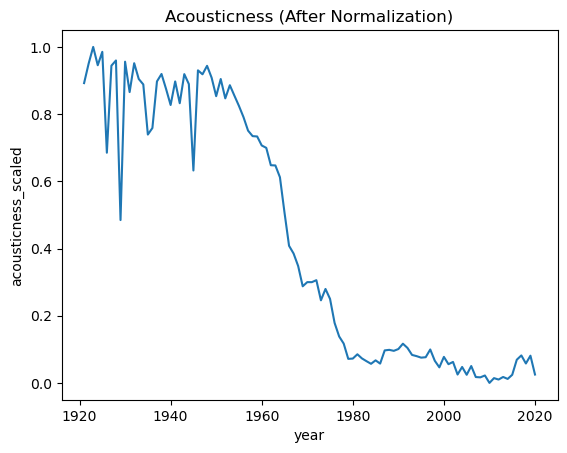

In [18]:
# Plot normalized data (after normalization)
sns.lineplot(x=acousticness_df.index, y='acousticness_scaled', data=acousticness_df)
plt.title('Acousticness (After Normalization)')
plt.show()

In [19]:
# Create a function to build sequences from the normalized data
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [25]:
TIME_STEPS = 10
X, y = acousticness_df[['acousticness_scaled']], acousticness_df['acousticness_scaled']

# splitting into train and test sets
split_index = int(len(X) * 0.8)
train, test = X[:split_index], X[split_index:]
y_train_full, y_test_full = y[:split_index], y[split_index:]

# train and test sequence creation
X_train, y_train = create_sequences(train, y_train_full, time_steps=TIME_STEPS)
X_test, y_test = create_sequences(test, y_test_full, time_steps=TIME_STEPS)


model = Sequential()

# add LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=30, return_sequences=False))

# add a Dropout layer to prevent overfitting
model.add(Dropout(0.25))

# add Dense layer with linear activation for regression output
model.add(Dense(units=1, activation='linear'))

# compile the model with Adam optimizer and mean squared error loss
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    shuffle=False
)


Epoch 1/100


C:\Users\adityamxr\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.6277 - val_accuracy: 0.0000e+00 - val_loss: 0.0018
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 0.1458 - val_accuracy: 0.0000e+00 - val_loss: 0.0423
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0000e+00 - loss: 0.0612 - val_accuracy: 0.0000e+00 - val_loss: 0.0365
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0550 - val_accuracy: 0.0000e+00 - val_loss: 0.0104
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0301 - val_accuracy: 0.0000e+00 - val_loss: 0.0030
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0658 - val_accuracy: 0.0000e+00 - val_loss: 0.0026
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0533 - val_accuracy: 0.0000e+00 - val_loss: 0.0055
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0129 - val_accuracy: 0.0000e+00 - val_loss: 0.0067
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0161 - val_accuracy: 0.0000e+00 - val_loss: 0.0060
Epoch 51/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0098 - val_accuracy: 0.0000e+00 - val_loss: 0.0054
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0146 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 0.0054
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 0.0056
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 0.0053
Epoch 56/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 7.2660e-04
Epoch 98/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0128 - val_accuracy: 0.0000e+00 - val_loss: 7.3145e-04
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 0.0103 - val_accuracy: 0.0000e+00 - val_loss: 7.4968e-04
Epoch 100/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0105 - val_accuracy: 0.0000e+00 - val_loss: 7.4572e-04


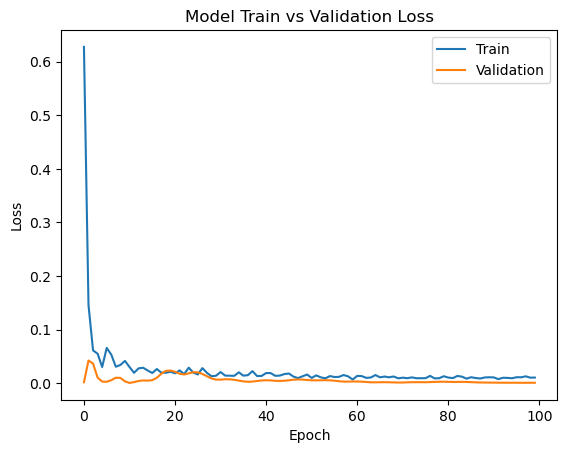

In [26]:
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [27]:
# predict using LSTM for both train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# inverse transform the predictions and actuals to get back to the original scale
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_inv = scaler.inverse_transform(y_train_pred)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


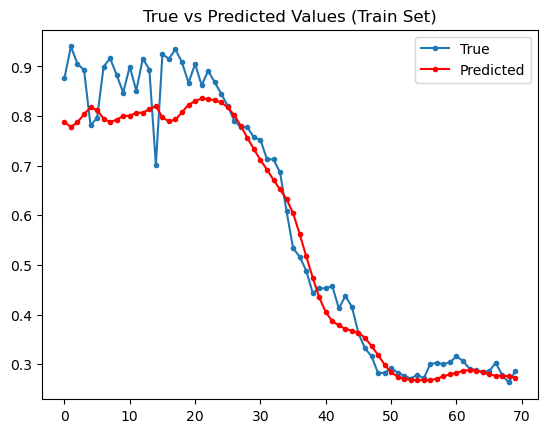

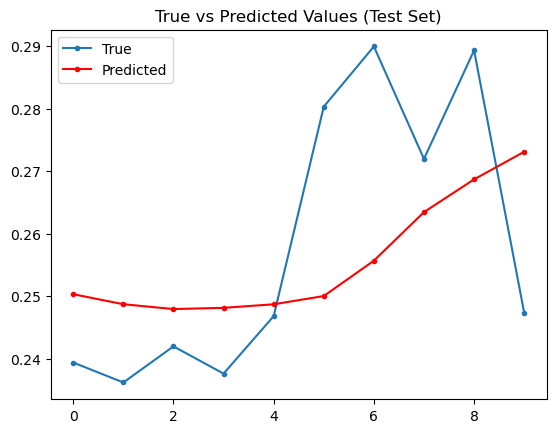

In [28]:
# plot true vs predicted for train set
plt.plot(y_train_inv, marker='.', label='True')
plt.plot(y_train_pred_inv, 'r', marker='.', label='Predicted')
plt.title('True vs Predicted Values (Train Set)')
plt.legend()
plt.show()

# plot true vs predicted for test set
plt.plot(y_test_inv, marker='.', label='True')
plt.plot(y_test_pred_inv, 'r', marker='.', label='Predicted')
plt.title('True vs Predicted Values (Test Set)')
plt.legend()
plt.show()

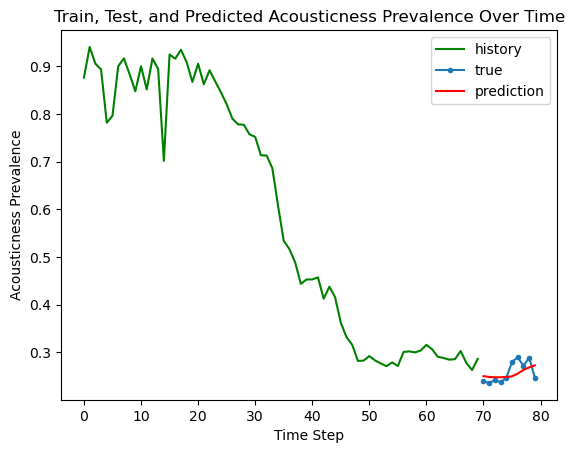

In [29]:
# combine the actual values from the train and test sets
plt.plot(np.arange(0, len(y_train_inv)), y_train_inv, 'g', label="history")  # Plot the history (training data)
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv, marker='.', label="true")  # Plot the true values for the test data
plt.plot(np.arange(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_pred_inv, 'r', label="prediction")  # Plot the predictions for the test data

# labels and legend
plt.ylabel('Acousticness Prevalence')
plt.xlabel('Time Step')
plt.legend()
plt.title('Train, Test, and Predicted Acousticness Prevalence Over Time')
plt.show()